In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from pathlib import Path
from sklearn.decomposition import PCA
from mbeml.featurization import get_ligand_features
from mbeml.constants import LigandFeatures

In [2]:
plt.style.use("mbeml.mbeml")

In [3]:
data_dir = Path("../../data")

df_train = pd.read_csv(data_dir / "training_data.csv")
df_val = pd.read_csv(data_dir / "validation_data.csv")
df_comp = pd.read_csv(data_dir / "composition_test_data.csv")
df_lig = pd.read_csv(data_dir / "ligand_test_data.csv")

In [4]:
# Prepare standard-RACs
standard_racs_train = get_ligand_features(df_train, LigandFeatures.STANDARD_RACS)
standard_racs_val = get_ligand_features(df_val, LigandFeatures.STANDARD_RACS)
standard_racs_comp = get_ligand_features(df_comp, LigandFeatures.STANDARD_RACS)
standard_racs_lig = get_ligand_features(df_lig, LigandFeatures.STANDARD_RACS)
# Normalize
norm_standard_racs = np.max(np.abs(standard_racs_train), axis=0)
norm_standard_racs[norm_standard_racs < 1e-6] = 1.0

standard_racs_train /= norm_standard_racs
standard_racs_val /= norm_standard_racs
standard_racs_comp /= norm_standard_racs
standard_racs_lig /= norm_standard_racs

In [5]:
# Prepare ligand-RACs
ligand_racs_train = get_ligand_features(df_train, LigandFeatures.LIGAND_RACS).reshape(
    len(df_train) * 6, -1
)
ligand_racs_val = get_ligand_features(df_val, LigandFeatures.LIGAND_RACS).reshape(
    len(df_val) * 6, -1
)
ligand_racs_comp = get_ligand_features(df_comp, LigandFeatures.LIGAND_RACS).reshape(
    len(df_comp) * 6, -1
)
ligand_racs_lig = get_ligand_features(df_lig, LigandFeatures.LIGAND_RACS).reshape(
    len(df_lig) * 6, -1
)
# Normalize
norm_ligand_racs = np.max(np.abs(ligand_racs_train), axis=0)
norm_ligand_racs[norm_ligand_racs < 1e-6] = 1.0

ligand_racs_train /= norm_ligand_racs
ligand_racs_val /= norm_ligand_racs
ligand_racs_comp /= norm_ligand_racs
ligand_racs_lig /= norm_ligand_racs

In [6]:
def unique_racs(racs):
    res = []
    for v in racs:
        for w in res:
            if np.linalg.norm(w - v) < 1e-6:
                break
        else:
            res.append(v)
    return np.array(res)

In [7]:
# Check that featurization is unique, training and val should have 107 unique ligands
assert len(unique_racs(np.concatenate([ligand_racs_train, ligand_racs_val]))) == 107
# Ligand test set should have 21 unique ligands
assert len(unique_racs(ligand_racs_lig)) == 21
# Check that there are not "collisions" between the 107 training/validation ligands and the 21 test ligands
assert (
    len(
        unique_racs(
            np.concatenate([ligand_racs_train, ligand_racs_val, ligand_racs_lig])
        )
    )
    == 107 + 21
)

In [8]:
# Find uniques
unique_standard_racs_train = unique_racs(standard_racs_train)
unique_standard_racs_val = unique_racs(standard_racs_val)
unique_standard_racs_comp = unique_racs(standard_racs_comp)
unique_standard_racs_lig = unique_racs(standard_racs_lig)
# Same for ligand-RACs
unique_ligand_racs_train = unique_racs(ligand_racs_train)
unique_ligand_racs_val = unique_racs(ligand_racs_val)
unique_ligand_racs_comp = unique_racs(ligand_racs_comp)
unique_ligand_racs_lig = unique_racs(ligand_racs_lig)

# 2D PCA

In [9]:
pca2d_standard = PCA(n_components=2)
pc_standard_racs_train = pca2d_standard.fit_transform(unique_standard_racs_train)
pc_standard_racs_val = pca2d_standard.transform(unique_standard_racs_val)
pc_standard_racs_comp = pca2d_standard.transform(unique_standard_racs_comp)
pc_standard_racs_lig = pca2d_standard.transform(unique_standard_racs_lig)

pca2d_ligand = PCA(n_components=2)
pc_ligand_racs_train = pca2d_ligand.fit_transform(unique_ligand_racs_train)
pc_ligand_racs_val = pca2d_ligand.transform(unique_ligand_racs_val)
pc_ligand_racs_comp = pca2d_ligand.transform(unique_ligand_racs_comp)
pc_ligand_racs_lig = pca2d_ligand.transform(unique_ligand_racs_lig)

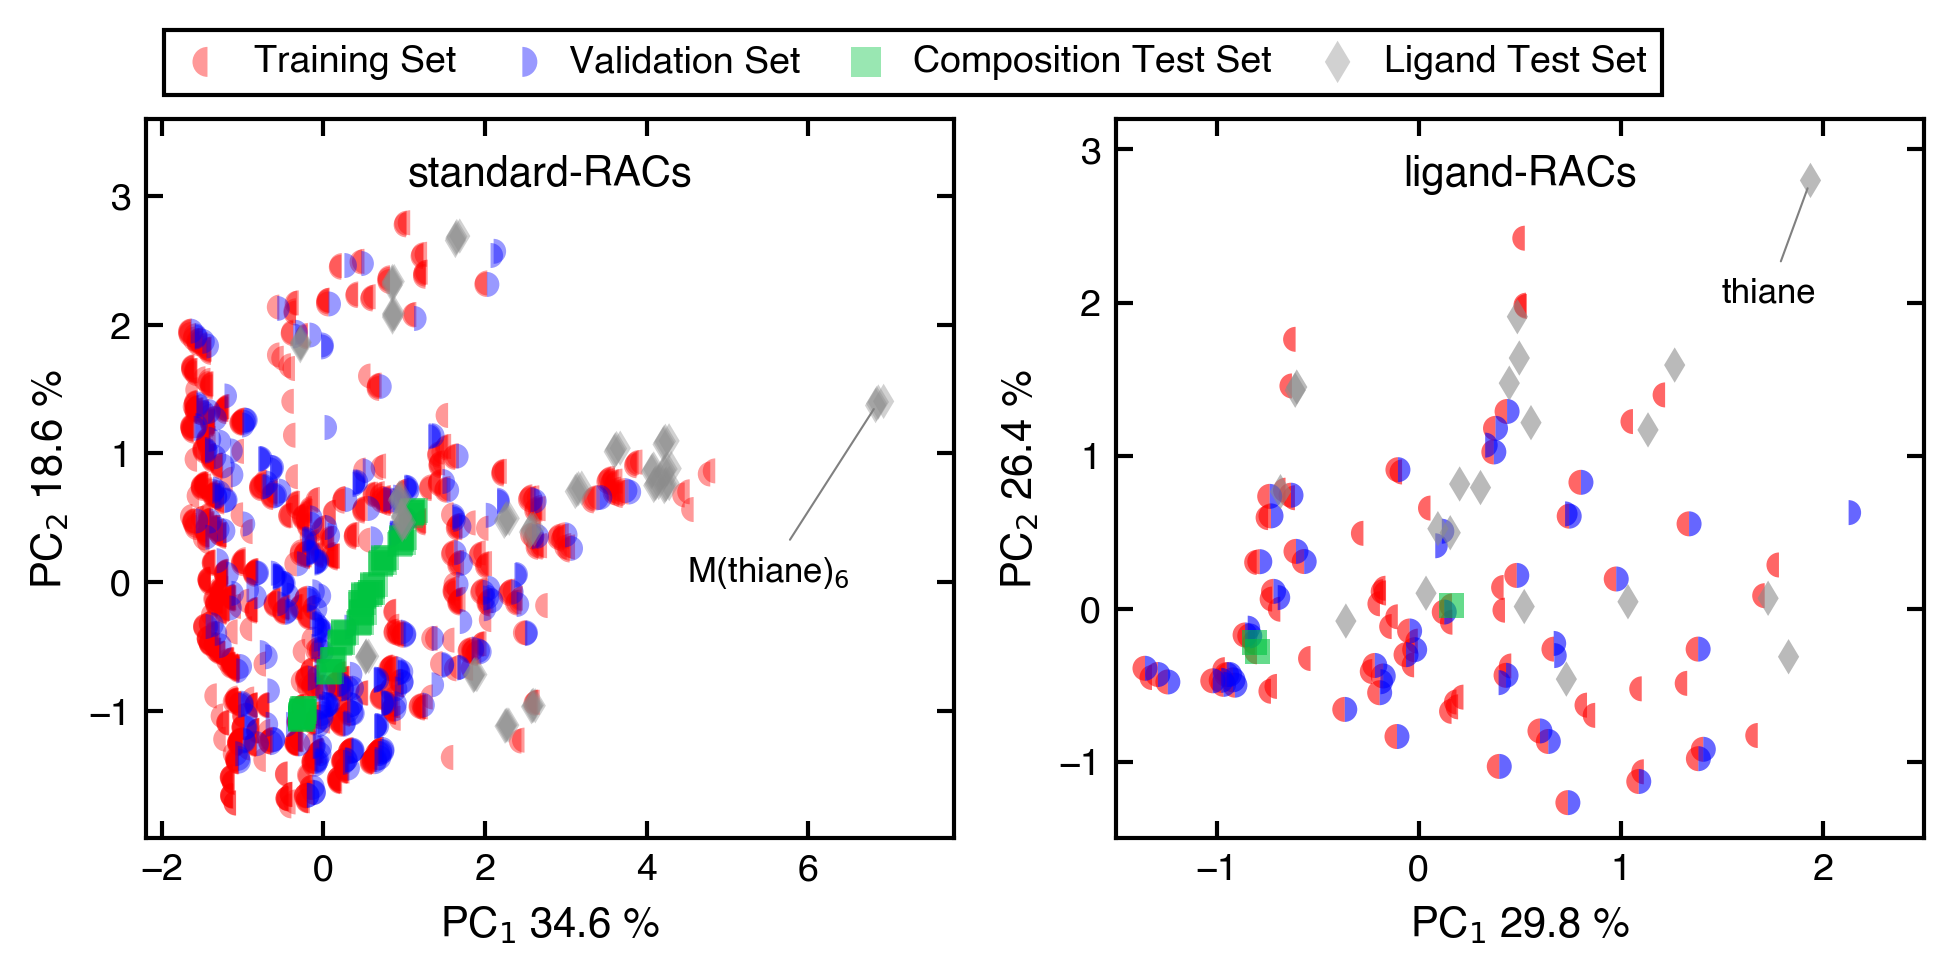

In [18]:
fig, ax = plt.subplots(
    figsize=(6.66, 0.5 * 6.66),
    dpi=300,
    ncols=2,
    gridspec_kw={
        "wspace": 0.2,
        "left": 0.08,
        "right": 0.97,
        "bottom": 0.15,
        "top": 0.87,
    },
)

scatter_kwargs = {"alpha": 0.4, "ec": "None"}

ax[0].scatter(
    pc_standard_racs_train[:, 0],
    pc_standard_racs_train[:, 1],
    marker=MarkerStyle("o", fillstyle="left"),
    label="Training Set",
    **scatter_kwargs,
)
ax[0].scatter(
    pc_standard_racs_val[:, 0],
    pc_standard_racs_val[:, 1],
    marker=MarkerStyle("o", fillstyle="right"),
    label="Validation Set",
    **scatter_kwargs,
)
ax[0].scatter(
    pc_standard_racs_comp[:, 0],
    pc_standard_racs_comp[:, 1],
    marker=MarkerStyle("s"),
    label="Composition Test Set",
    **scatter_kwargs,
)
ax[0].scatter(
    pc_standard_racs_lig[:, 0],
    pc_standard_racs_lig[:, 1],
    marker=MarkerStyle("d"),
    label="Ligand Test Set",
    **scatter_kwargs,
)
ax[0].text(0.5, 0.95, "standard-RACs", transform=ax[0].transAxes, ha="center", va="top")
ax[0].set_xlabel(f"PC$_1$ {pca2d_standard.explained_variance_ratio_[0]*100:.1f} %")
ax[0].set_ylabel(f"PC$_2$ {pca2d_standard.explained_variance_ratio_[1]*100:.1f} %")
ax[0].set_xlim(-2.2, 7.8)
ax[0].set_ylim(-1.99, 3.6)

ax[0].annotate(
    "M(thiane)$_6$",
    xy=pc_standard_racs_lig[17],
    xytext=(4.5, 0.0),
    fontsize="small",
    arrowprops=dict(arrowstyle="-", linewidth=0.5, color="0.5"),
)

ax[0].legend(ncols=4, loc="upper left", bbox_to_anchor=(0.0, 1.15))

# Slightly higher alpha because we expect less overlap
scatter_kwargs = {"alpha": 0.6, "ec": "None"}

ax[1].scatter(
    pc_ligand_racs_train[:, 0],
    pc_ligand_racs_train[:, 1],
    marker=MarkerStyle("o", fillstyle="left"),
    **scatter_kwargs,
)
ax[1].scatter(
    pc_ligand_racs_val[:, 0],
    pc_ligand_racs_val[:, 1],
    marker=MarkerStyle("o", fillstyle="right"),
    **scatter_kwargs,
)
ax[1].scatter(
    pc_ligand_racs_comp[:, 0],
    pc_ligand_racs_comp[:, 1],
    marker=MarkerStyle("s"),
    **scatter_kwargs,
)
ax[1].scatter(
    pc_ligand_racs_lig[:, 0],
    pc_ligand_racs_lig[:, 1],
    marker=MarkerStyle("d"),
    **scatter_kwargs,
)
ax[1].text(0.5, 0.95, "ligand-RACs", transform=ax[1].transAxes, ha="center", va="top")
ax[1].set_xlabel(f"PC$_1$ {pca2d_ligand.explained_variance_ratio_[0]*100:.1f} %")
ax[1].set_ylabel(f"PC$_2$ {pca2d_ligand.explained_variance_ratio_[1]*100:.1f} %")
ax[1].set_xlim(-1.5, 2.5)
ax[1].set_ylim(-1.5, 3.2)
ax[1].annotate(
    "thiane",
    xy=pc_ligand_racs_lig[17],
    xytext=(1.5, 2.0),
    fontsize="small",
    arrowprops=dict(arrowstyle="-", linewidth=0.5, color="0.5"),
)

fig.savefig("plots/pca_feature_spaces.pdf")

# Locate Outliers

In [11]:
# Standard-RACs: Ligand Test Set outlier:
inds = np.where(pc_standard_racs_lig[:, 0] > 6.0)[0]
# Find the corresponding complexes in df_lig
for ind in inds:
    # Find the closest feature vector in the whole set
    df_ind = np.argmin(
        np.sum((standard_racs_lig - unique_standard_racs_lig[ind]) ** 2, axis=-1)
    )
    # Get the corresponding name
    print(ind, df_lig.iloc[df_ind]["name"])

17 co_2_thiane_thiane_thiane_thiane_thiane_thiane
38 fe_2_thiane_thiane_thiane_thiane_thiane_thiane
57 mn_2_thiane_thiane_thiane_thiane_thiane_thiane
81 cr_3_thiane_thiane_thiane_thiane_thiane_thiane


In [58]:
# Ligand-RACs: Ligand Test Set outlier:
inds = np.where(pc_ligand_racs_lig[:, 1] > 2.7)[0]
# Find the corresponding ligand
ind = inds[0]
ind_1D = np.argmin(
    np.sum(
        (ligand_racs_lig.reshape([len(df_lig), 6, 33]) - unique_ligand_racs_lig[ind])
        ** 2,
        axis=-1,
    )
)
ind_2D = np.unravel_index(ind_1D, (len(df_lig), 6))
print(ind, df_lig.iloc[ind_2D[0]]["name"].split("_")[2 + ind_2D[1]])

17 thiane


In [29]:
mask = df_lig["name"].str.contains("[PH]=[CH]", regex=False)
df_lig[mask]

,name,metal,ox,high_spin,spin_splitting_kcal/mol,energetic_homo_ls_eV,energetic_homo_hs_eV,energetic_lumo_ls_eV,energetic_lumo_hs_eV,energetic_gap_ls_eV,...,lig6_D_T_1,lig6_D_S_1,lig6_D_Z_2,lig6_D_chi_2,lig6_D_T_2,lig6_D_S_2,lig6_D_Z_3,lig6_D_chi_3,lig6_D_T_3,lig6_D_S_3
7,co_2_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[...,co,2,4,0.146737,-11.589329,-11.592050,-9.270919,-9.284525,2.318410,...,0.0,1.07,21.0,-1.26,1.0,1.17,14.0,-0.01,1.0,0.76
36,fe_2_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[...,fe,2,5,-5.504144,-11.967568,-11.880491,-8.136204,-8.998805,3.831363,...,0.0,1.07,21.0,-1.26,1.0,1.17,14.0,-0.01,1.0,0.76
55,fe_3_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[...,fe,3,6,4.273363,-15.200280,-14.794831,-12.721323,-14.103661,2.478957,...,0.0,1.07,21.0,-1.26,1.0,1.17,14.0,-0.01,1.0,0.76
70,mn_2_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[...,mn,2,6,-33.440372,-11.537628,-11.877770,-8.718528,-8.152531,2.819100,...,0.0,1.07,21.0,-1.26,1.0,1.17,14.0,-0.01,1.0,0.76
97,cr_2_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[...,cr,2,5,-37.058357,-11.464157,-11.260072,-9.235544,-8.821931,2.228613,...,0.0,1.07,21.0,-1.26,1.0,1.17,14.0,-0.01,1.0,0.76
114,cr_3_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[...,cr,3,4,-24.081225,-15.183953,-15.151300,-12.870986,-12.555334,2.312968,...,0.0,1.07,21.0,-1.26,1.0,1.17,14.0,-0.01,1.0,0.76


In [59]:
ligand_racs_phchoh = ligand_racs_lig.reshape(len(df_lig), 6, 33)[7, 0, :]
np.argsort(np.sum((ligand_racs_phchoh - unique_ligand_racs_train) ** 2, axis=1))

array([65, 64, 40, 12, 51, 54, 58, 21, 50, 59, 60, 61, 95, 20, 18, 17,  9,
       56,  7, 27, 35, 16, 22, 52, 39, 36,  3, 89, 57, 63,  8, 53,  6, 37,
       28, 82, 67, 43, 90, 19, 32, 11, 73,  4, 87, 38, 14, 34, 42, 41, 92,
       75, 29, 79,  2, 74, 13, 49, 23, 78, 70, 48, 25, 45,  5,  1, 94, 88,
       30, 77, 33, 44,  0, 46, 81, 10, 31, 76, 26, 85, 86, 62, 47, 15, 24,
       72, 93, 83, 84, 55, 80, 66, 91, 69, 68, 71])

In [75]:
ind = 40
ind_1D = np.argmin(
    np.sum(
        (
            ligand_racs_train.reshape([len(df_train), 6, 33])
            - unique_ligand_racs_train[ind]
        )
        ** 2,
        axis=-1,
    )
)
ind_2D = np.unravel_index(ind_1D, (len(df_train), 6))
print(ind, df_train.iloc[ind_2D[0]]["name"].split("_")[2 + ind_2D[1]])

40 [SH]-[OH]
